In [497]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
from sklearn.metrics import accuracy_score

# Data preparation

In [498]:
# Load data 
data = fetch_ucirepo(id=45)

# Extract predicotrs 
X = data['data']['features']
display(X.head())

# Dependent variable - target
y = data['data']['targets']
y = y.rename(columns= {'num': "HeartDisease"})
display(y.head())

# Metadata
variables_df  = data['variables']
display(variables_df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


,HeartDisease
0,0
1,2
2,1
3,0
4,0


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [499]:
# Keep features with no null values 
cols_keep = variables_df[variables_df['missing_values'] == 'no']['name'].values.tolist()
cols_keep.remove('num')
X = X[cols_keep]

# Convert sex, cp, fbs, restecg, exang, slope to object datatype
cat_cols = ['sex', 'cp', 'fbs' ,'restecg', 'exang', 'slope']
X[cat_cols] = X[cat_cols].astype('object')

display(X.head())

# Convert y to binary
y['HeartDisease']  = y['HeartDisease'].apply(lambda x : 1 if x > 0 else 0  )
display(y.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1,1,145,233,1,2,150,0,2.3,3
1,67,1,4,160,286,0,2,108,1,1.5,2
2,67,1,4,120,229,0,2,129,1,2.6,2
3,37,1,3,130,250,0,0,187,0,3.5,3
4,41,0,2,130,204,0,2,172,0,1.4,1


,HeartDisease
0,0
1,1
2,1
3,0
4,0


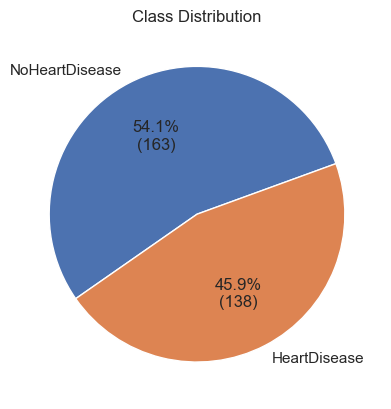

In [500]:
# Show class split
group = y.groupby('HeartDisease')['HeartDisease'].count()

# Function to diplay percentage and absolute value in pie chart
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.title('Class Distribution')
plt.pie(group, labels=['NoHeartDisease', 'HeartDisease'], autopct=lambda pct: func(pct, group),  startangle = 20)
plt.show()

In [501]:
# Split data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2)

# Uncertainty metrics used in random forest

### Entropy

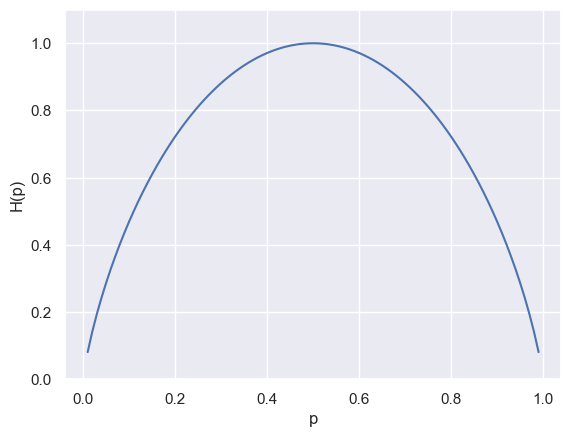

In [502]:
def entropy(p):
    if p == 0 or p  == 1:
        return 0
    else:
        return - (p * np.log2(p) + (1 - p) * np.log2(1-p))

ps =np.arange(0,1,0.01).tolist()
Hs = [H(i) for  i in ps]

plt.plot(ps, Hs)
plt.xlabel('p')
plt.ylabel('H(p)')
plt.ylim([0,1.1])
plt.show()

### Gini impurity

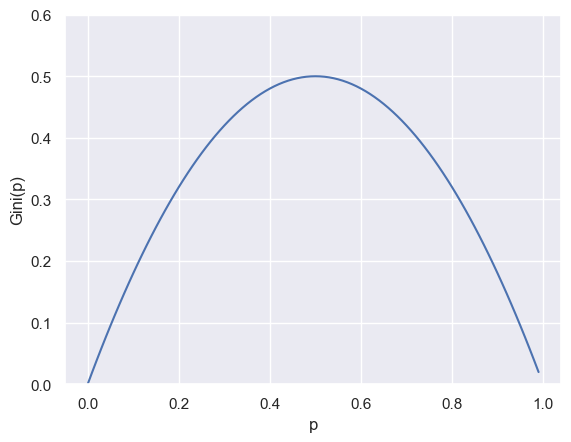

In [503]:
def Gini(p):
    if p == 0 or p  == 1:
        return 0
    else:
        q = 1-p
        return p * (1-p)  + q *(1-q)

ps = np.arange(0,1,0.01).tolist()
Ginis = [Gini(i) for  i in ps]

plt.plot(ps, Ginis)
plt.xlabel('p')
plt.ylabel('Gini(p)')
plt.ylim([0,0.6])
plt.show()

# Ramdom forests model

### Functions to create the random forest model

In [519]:
# Function to calculate information gain 
def information_gain(left_child_node, right_child_node):
    p_left = np.mean(left_child_node)
    p_right = np.mean(right_child_node)
    l_left = left_child_node.shape[0]
    l_right = right_child_node.shape[0]
    l_parent = l_left + l_right
    p_parent = p_left * l_left / l_parent +  p_right * l_right / l_parent
    E_p = entropy(p_parent)
    E_l = entropy(p_left)
    E_r = entropy(p_right)
    IG_split = E_p - l_left / l_parent* E_l - l_right / l_parent * E_r
    if np.isnan(IG_split):
        return 0
    else:
        return IG_split


# Function to create bootstrap and out of bag - OOB sample
def draw_bootstrap(X, y ):
    bootstrap_idx  = list(np.random.choice(range(len(X)), len(X), replace = True)) 
    oob_idx  = [i for i in range(len(X)) if i not in bootstrap_idx]
    X_bootstrap, y_bootstrap = X.iloc[bootstrap_idx], y.iloc[bootstrap_idx]
    X_OOB, y_OOB = X.iloc[oob_idx], y.iloc[oob_idx]
    return X_bootstrap, y_bootstrap, X_OOB, y_OOB 

# Function that return the class of the terminal node
def create_terminal_node(child_node):
    # It terminal nodes, we don't split but return prediction --> most common class
    y  = child_node['y']
    prediction = np.mean(y)
    class_node = np.round(prediction)
    return class_node # if class_node != None else dataset_mean

# function to find best split 
def find_best_split(X_boot, y_boot , n_features):

    # 1- Check if y_boot contains all 1s or all 0s (pure node) : splitting is not needed and we return the class  *
    if np.mean(y_boot) == 1:
        return 0
    if np.mean(y_boot) == 0:
        return 0

    # 2-Otherwise we seek the best split
    # First ignore those categorical variables that contains one single unique values (splitting makes no sense)
    object_columns = X_boot.select_dtypes(include=['object'])
    single_unique_value_columns = []
    for column in object_columns:
        if len(X_boot[column].unique()) == 1:
            single_unique_value_columns.append(column)
    all_valid_features = [i for i in X_boot.columns if i not in single_unique_value_columns] 

    # Select n_features features from all valid features of X 
    features = np.random.choice(all_valid_features, size=n_features, replace = False)

    # Add y to X to save lines of code later
    X_y_boot = X_boot.copy()
    X_y_boot['y'] = y_boot.values

    best_IG = 0
    
    # Create empty split data that it will populated when the best split is found
    best_split_data = {'feature' : None, 
                        'datatype': None, 
                        'value': None,
                        "left_node" : { "X": [] , "y": [], "class":None },
                        "right_node" : { "X": [] , "y": [], "class":None }}
    
    # Loop over each feature and its value until the best interfomation gain is found
    #print(X_y_boot)
    for feature in features:
        if X_y_boot[feature].dtypes == 'object':
            for cat in X_y_boot[feature].unique().tolist():
                left = X_y_boot[X_y_boot[feature] == cat]
                right = X_y_boot[X_y_boot[feature] != cat]

                IG  = information_gain(left['y'], right['y'])
                #print('categorical IG', IG)
                if IG > best_IG: 
                    best_IG = IG 
                    best_split_data = {'feature' : feature, 
                                       'datatype': "categorical", 
                                       'value': cat,
                                       "left_node" : { "X": left.drop('y', axis = 1) , "y": left['y'] },
                                       "right_node" : { "X": right.drop('y', axis = 1) , "y": right['y'] }}
        else:
            # collect all values for the numerical values
            all_values = X_y_boot[feature].unique().tolist()
            # sort in ascending order
            all_values.sort(reverse=False)
            # loop over each split
            for value in all_values[:-1]:
                left = X_y_boot[X_y_boot[feature] > value]
                right = X_y_boot[X_y_boot[feature] <= value ]

                IG  = information_gain(left['y'], right['y'])
                #print('categorical IG', IG)
                if IG > best_IG: 
                    best_IG = IG 
                    best_split_data = {'feature' : feature, 
                                       'datatype': "numerical", 
                                       'value': value,
                                       "left_node" : { "X": left.drop('y', axis = 1) , "y": left['y']},
                                       "right_node" : { "X": right.drop('y', axis = 1) , "y": right['y'] }}

    # If no split led to information gain > 0 both left node X and right node X are [] --> we will return the class of the node 
    if len(best_split_data['left_node']['X'])  == 0 and len(best_split_data['right_node']['X'])  == 0:
        return np.rounf(np.mean(y_boot))

    # Return split information with highest IG
    return best_split_data

# Main function
def recursive_splitting(node_split, n_features, min_leaf_size, max_depth, depth):
    # input is node split which is a dictionary unless the a pure node was passed to find_best_split (*) 
    if type(node_split) == dict:
        # Extract left and right child node 
        left_node = node_split['left_node'] 
        right_node = node_split['right_node']

        # If a child is empty return the mean class across the boostrap. For the other one return the most common class 
        if len(left_node['X']) == 0:
            #print('dataset_mean', dataset_mean)
            node_split['left_node'] = dataset_mean
            node_split['right_node'] = create_terminal_node(right_node)
            return node_split

        elif len(right_node['X']) == 0:
            print('dataset_mean', dataset_mean)
            node_split['left_node'] = create_terminal_node(right_node)
            node_split['right_node'] = dataset_mean
            return node_split
        
        # if depth of tree if higher than a max preset value , return class
        if  depth >= max_depth:

            node_split['left_node'] = create_terminal_node(left_node)
            node_split['right_node'] = create_terminal_node(right_node)

            return node_split
        
        # If the number of samples in LEFT leaf is lower than a preset value, stop splitting and return the prediction
        if len(left_node['X']) <= min_leaf_size:
            node_split['left_node'] = node_split['left_node'] = create_terminal_node(left_node)
        # otherwise continue splitting
        else:
            node_split['left_node']  = find_best_split(left_node['X'] , left_node['y'], n_features)
            recursive_splitting(node_split['left_node'], n_features, min_leaf_size, max_depth, depth + 1 )
        
        # if the number of samples in RIGHT leaf is lower than a preset value, stop splitting and return the prediction
        if len(right_node['X']) <= min_leaf_size:
            node_split['right_node'] = node_split['right_node'] = create_terminal_node(left_node)

        # otherwise continue splitting
        else:
            node_split['right_node']  = find_best_split(right_node['X'] , right_node['y'], n_features)
            recursive_splitting(node_split['right_node'], n_features, min_leaf_size, max_depth, depth + 1 )

def create_single_tree(X_boot, y_boot, max_depth, min_leaf_size, n_features):
    # First the root node is splitted 
    root_node = find_best_split(X_boot, y_boot, n_features)

    # Recursively each node is split expanding the dictionary that is the tree
    recursive_splitting(root_node, n_features, min_leaf_size, max_depth, 1)
    return root_node

def random_forest(X, y, n_estimators,  max_depth, min_leaf_size, n_features):
    global dataset_mean
    dataset_mean = np.round(np.mean(y))
    trees = list()
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)

    for i in range(n_estimators):
        X_b, y_b, _, _ = draw_bootstrap(X,y)
        tree = create_single_tree(X_b, y_b, max_depth, min_leaf_size, n_features)
        trees.append(tree)

    return trees

### Functions to make predictions 

In [520]:
# Give a single tree and a row, walk down the dictionary and predict the class of the row 
def make_tree_single_prediction_one_row(tree , row):
    feature = tree['feature']
    value = tree['value']
    datatype = tree['datatype']
    if datatype =='numerical':
        if row[feature] > value:
            left = tree['left_node']
            if type(left) == dict:
                #print(left)
                return make_tree_single_prediction_one_row(left, row)

            else:
                return left
        else:
            right = tree['right_node']
            if type(right) ==dict:
                #print(right)
                return make_tree_single_prediction_one_row(right, row)
            else:
                return right
    elif datatype =='categorical':
        if row[feature] == value:
            left = tree['left_node']
            if type(left) == dict:
                #print(left)
                return make_tree_single_prediction_one_row(left, row)
            else:
                return  left
        else:
            right = tree['right_node']
            if type(right) ==dict:
                #print(right)
                return make_tree_single_prediction_one_row(right, row)
            else:
                return right

# Make prediction for all rows in the dataset for one tree
def make_tree_prediction(tree, X ):
    preds = []
    for _, x in X.iterrows():
        pred = make_tree_single_prediction_one_row(tree, x)
        preds.append(pred)

    return preds

# Collect prediction of all trees and spit out random forest ensemble prediction
def rf_prediction(rf_model, X, y ):
    rf_model_preds =[]
    for rf in rf_model:
        rf_model_preds.append(make_tree_prediction(rf, X))

    arr = np.array(rf_model_preds)
    model_pred  = np.round(np.mean(arr , axis = 0))

    print(f"accuracy {np.round(accuracy_score(model_pred, y ),3)}")


### Fit random forests model and calculate accuracy on train and test set

In [518]:
# Hyperparams
N_TREES = 100
MAX_DEPTH = 4
MIN_LEAF_SIZE = 2 # min number of samples in the leaf  
N_FEATURES = int(np.sqrt(X.shape[1]))

# Create a random forest model
model  = random_forest(X = X_train, 
                       y = y_train , 
                       n_estimators = N_TREES,
                       max_depth = MAX_DEPTH,     
                       min_leaf_size = MIN_LEAF_SIZE, 
                       n_features = N_FEATURES)

# Calculate accuracy on train set 
print("TRAIN SET:")
rf_prediction(model, X_train, y_train)

# Calculate accuracy on test set 
print("TEST SET:")
rf_prediction(model, X_test, y_test)

TRAIN SET:
accuracy 0.851
TEST SET:
accuracy 0.852


### Display one single tree

In [521]:
import pprint

pprint.pprint(model[0],sort_dicts=False)

{'feature': 'thalach',
 'datatype': 'numerical',
 'value': 160,
 'left_node': {'feature': 'sex',
               'datatype': 'categorical',
               'value': 0,
               'left_node': {'feature': 'age',
                             'datatype': 'numerical',
                             'value': 63,
                             'left_node': {'feature': 'oldpeak',
                                           'datatype': 'numerical',
                                           'value': 0.4,
                                           'left_node': 1.0,
                                           'right_node': 0.0},
                             'right_node': 0},
               'right_node': {'feature': 'oldpeak',
                              'datatype': 'numerical',
                              'value': 0.5,
                              'left_node': {'feature': 'thalach',
                                            'datatype': 'numerical',
                                            

# Using sklearn  RandomForestClassifier

In [522]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier()

cls.fit(X_train, y_train)
test_pred = cls.predict(X_test)

print("TEST SET:")
print('accuracy', accuracy_score(test_pred, y_test))

TEST SET:
accuracy 0.819672131147541
